In [1]:
import numpy as np
import pandas as pd
from copy import deepcopy
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

c:\Users\yifen\anaconda3\envs\AIHacks\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Introduction


*   Finding the relationship between the composition/structure and properties of materials is a holy grail of material science. Various models ranging from QM methods on the atomic scale to FEM on the macroscopic scale have been developed in the past century. More recently, ML-based approaches have gained momentum.
*   Here, we provide a toy dataset of alloys `toy_alloy_data.csv`. The first 12 columns correspond to the proportion of 12 elements (i.e. the first 12 columns of any row should sum to 1). The last 6 columns correspond to 6 properties (Each property column has been normalised so that its mean and standard deviation are 0 and 1, respectively). 



In [2]:
toy_alloy_data = pd.read_csv("data/toy_alloy_data.csv")
X_name = [f'element {i}' for i in range(1,13)]
Y_name = [f'property {i}' for i in range(1,7)]

In [3]:
toy_alloy_data.describe()

,element 1,element 2,element 3,element 4,element 5,element 6,element 7,element 8,element 9,element 10,element 11,element 12,property 1,property 2,property 3,property 4,property 5,property 6
count,4612.000000,4612.000000,4612.000000,4612.000000,4612.000000,4612.000000,4612.000000,4612.000000,4612.000000,4612.000000,4612.000000,4612.000000,4.612000e+03,4.612000e+03,4.612000e+03,4.612000e+03,4.612000e+03,4.612000e+03
mean,0.419336,0.040728,0.009421,0.042242,0.007931,0.203768,0.000311,0.001710,0.000181,0.032633,0.001262,0.240479,-3.191470e-16,-4.357120e-17,8.902005e-17,-1.714683e-16,-1.644965e-13,-3.322003e-17
std,0.435785,0.076945,0.016830,0.115915,0.016362,0.362367,0.000952,0.004197,0.000389,0.104186,0.001974,0.411919,1.000108e+00,1.000108e+00,1.000108e+00,1.000108e+00,1.000108e+00,1.000108e+00
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.082560e-01,-1.148295e+00,-2.919913e+00,-9.310694e-01,-2.724788e+01,-1.207390e+00
25%,0.003968,0.000000,0.000991,0.000000,0.000996,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.082560e-01,-1.044864e+00,-4.468705e-01,-9.240504e-01,1.750028e-02,-8.248388e-01
50%,0.051852,0.001395,0.007878,0.000000,0.003957,0.002470,0.000237,0.000201,0.000090,0.000000,0.000000,0.000000,-1.082560e-01,-4.368803e-01,1.533713e-01,-6.737728e-01,2.279300e-02,-1.572499e-01
75%,0.948544,0.013826,0.010929,0.016726,0.008841,0.049140,0.000349,0.001947,0.000281,0.002451,0.001513,0.389568,-9.935497e-02,1.192823e+00,8.322118e-01,1.285551e+00,2.367406e-02,5.178401e-01
max,0.999350,0.581123,0.413413,0.986388,0.190476,1.000000,0.015780,0.037486,0.006713,0.999920,0.014677,0.996910,5.467245e+01,1.315811e+00,8.443982e-01,1.430488e+00,3.963239e+01,1.229441e+01


# A simple NN model for the composition to property problem


*   It is generally not difficult to build a model to predict properties from composition. Here we show how to train a simple neural network model for the composition to property problem using PyTorch. 

**Note:** In the code below, we did not split the data into training, validation and testing sets, which you probably should not do.






In [4]:
# a simple MLP with three hidden layers and tanh activation
m = nn.Sequential(nn.Linear(12, 12), nn.Tanh(), nn.Linear(12, 9), nn.Tanh(), nn.Linear(9, 6))
m.double()
# a simple training procedure with MSE loss and Adam optimiser
def train(m, x, y,  max_iter=20000):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(m.parameters())
    loss_hist = []
    R2_hist = []
    y_bar = torch.mean(y, 0)

    for t in range(1, max_iter + 1):
        y_pred = m(x)
        loss = criterion(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if t % 100 == 0:
            loss_hist.append(loss.detach())
            R2 = 1 - torch.sum((y - y_pred)**2, 0) / torch.sum((y - y_bar)**2, 0)
            R2 = torch.mean(R2)
            R2_hist.append(R2.detach())
            print(f'epoch: {t}, loss: {float(loss.item()):.4f}, R^2: {float(R2):.4f}')
            if len(loss_hist) > 2 and torch.abs((loss_hist[-1]-loss_hist[-2])/loss_hist[-1]) < 1e-6:
                break
    return m, loss_hist, R2_hist

In [5]:
X = torch.tensor(toy_alloy_data[X_name].values)
Y = torch.tensor(toy_alloy_data[Y_name].values)

In [6]:
m, loss_hist, R2_hist= train(m, X, Y, max_iter=30000)

epoch: 100, loss: 0.7544, R^2: 0.2456
epoch: 200, loss: 0.5629, R^2: 0.4371
epoch: 300, loss: 0.5376, R^2: 0.4624
epoch: 400, loss: 0.5139, R^2: 0.4861
epoch: 500, loss: 0.5025, R^2: 0.4975
epoch: 600, loss: 0.4964, R^2: 0.5036
epoch: 700, loss: 0.4931, R^2: 0.5069
epoch: 800, loss: 0.4906, R^2: 0.5094
epoch: 900, loss: 0.4884, R^2: 0.5116
epoch: 1000, loss: 0.4864, R^2: 0.5136
epoch: 1100, loss: 0.4847, R^2: 0.5153
epoch: 1200, loss: 0.4832, R^2: 0.5168
epoch: 1300, loss: 0.4818, R^2: 0.5182
epoch: 1400, loss: 0.4805, R^2: 0.5195
epoch: 1500, loss: 0.4793, R^2: 0.5207
epoch: 1600, loss: 0.4780, R^2: 0.5220
epoch: 1700, loss: 0.4768, R^2: 0.5232
epoch: 1800, loss: 0.4755, R^2: 0.5245
epoch: 1900, loss: 0.4741, R^2: 0.5259
epoch: 2000, loss: 0.4726, R^2: 0.5274
epoch: 2100, loss: 0.4710, R^2: 0.5290
epoch: 2200, loss: 0.4693, R^2: 0.5307
epoch: 2300, loss: 0.4675, R^2: 0.5325
epoch: 2400, loss: 0.4657, R^2: 0.5343
epoch: 2500, loss: 0.4639, R^2: 0.5361
epoch: 2600, loss: 0.4623, R^2: 0.

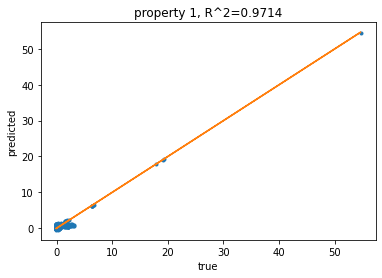

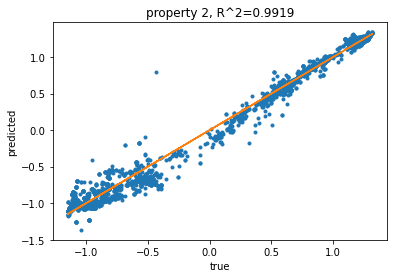

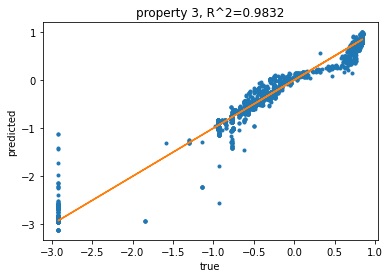

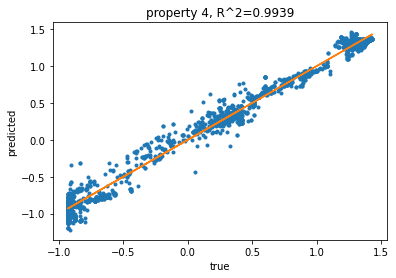

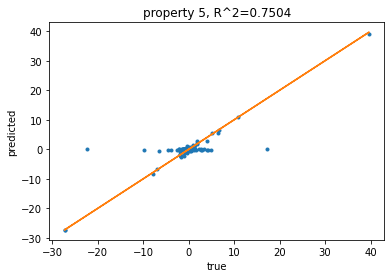

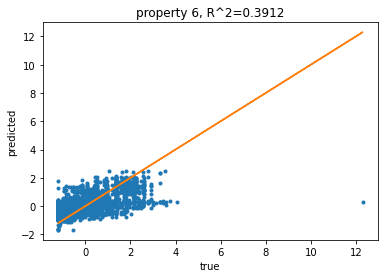

In [7]:
with torch.no_grad():
    Y_pred = m(X).numpy()
Y_true = Y.numpy()

for i in range(6):
    Y_bar = np.mean(Y_true[:,i])
    R_2 = 1 - np.sum((Y_true[:,i] - Y_pred[:,i])**2) / np.sum((Y_true[:,i] - Y_bar)**2)
    plt.plot(Y_true[:, i], Y_pred[:, i], '.')
    plt.plot(Y_true[:, i], Y_true[:, i], '-')
    plt.xlabel('true')
    plt.ylabel('predicted')
    plt.title(f'{Y_name[i]}, R^2={R_2:.4f}')
    plt.show()

# The Challenge

*   The performance of the NN model above seems not too bad. Can you try to improve it?
*   More importantly, can you find a way to predict compositions from a given set of desired properties? You are not restricted to NN models only. However,  note the output should all be positive and sum to one.

